# Interfaces


In [ ]:
def makeFishGo(flipping_frequency, flipping_amplitude, phase_shift, target, amplitude_controller, elementRatio, plot=False):
    #calculation performed elsewhere
    timeToTarget, energyUsedToTarget, maxVelocity = 1
    return timeToTarget, energyUsedToTarget, maxVelocity

def fishControllers(option, x, target):
  if option == 1:
      #The fish swims at a constant speed until target, at which point it stops flipping
      controller = 0
  elif option == 2:
      #The fish swims at max speed and then decreases gradually as it approaches the target
      controller = 0
  elif option == 3:
      #The fish increases its speed until halfway, and then decreases gradually as it approaches the target
      controller = 0
  else:
      raise ValueError("Invalid controller option")

# Studying just one element

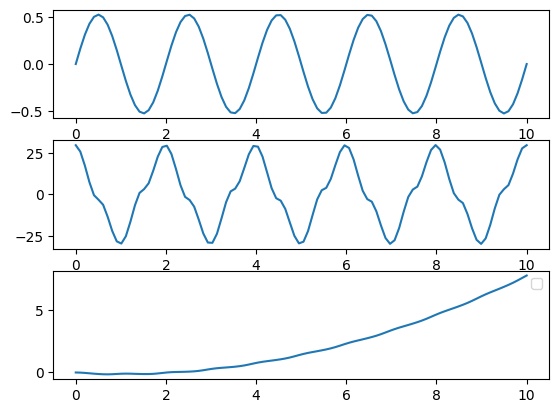

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1.5
H = 0.285*fork_length
L = 0.1*H
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2

m = 4
N = 100  # number of fin elements
dr = L/N  # length of each element

omega = np.pi
theta0_max = 0.125  # max angle in radians
phi = 0.05

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha[0], alpha[1], alpha[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal(xf, r, alpha, theta):
  v_n = xf[1] * np.sin(alpha[0]) + r * (alpha[1] + theta[1])
  return v_n

def vd_normal(xf, r, alpha, theta):
  dv_n = r * (theta[2] + alpha[2]) + alpha[1] * xf[1] * np.cos(alpha[0]) + xf[2] * np.sin(alpha[0])
  return dv_n

def dFd_a(dv_n):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha, theta):
  dFd = dFd_a(vd_normal(xf, r, alpha, theta)) + dFd_s(v_normal(xf, r, alpha, theta))
  return dFd

# time
total_time = 10  # total time for the journey in seconds
num = 100
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
alpha = np.zeros((3, num))

alpha[0] = np.pi/6 * np.sin(omega * t)
alpha[1] = omega * np.pi/6 * np.cos(omega * t)
alpha[2] = - omega**2 * np.pi/6 * np.sin(omega * t)

theta = [0, 0, 0] # Fish does not rotate

dFd = np.zeros(num)

dt = total_time / num

for i in range(num):
  dFd[i] = dFd_net(xf[:, i], r, alpha[:, i], theta)
  xf[2,i] = - dFd[i] * np.sin(alpha[0,i])/m
  xf[1,i] = xf[1,i-1] + xf[2,i] * dt
  xf[0,i] = xf[0,i-1] + xf[1,i] * dt


plt.subplot(3, 1, 1)
plt.plot(t, alpha[0], label = 'alpha')
# plt.plot(t, alpha[1], label = 'alphad')
# plt.plot(t, alpha[2], label = 'alphadd')

plt.subplot(3,1,2)
plt.plot(t, dFd)

plt.subplot(3,1,3)
plt.plot(t, xf[0])

plt.legend()

# Studying just one Fin

Solved for one fin with Euler's method. RMSE low enough to show that the blade element method is comparable to the analytical solution

RMSE was the same with or without taking the acceleratin of the fish into consideration. Acceleration of the fish in this case was only 0.1 at max

Will take acceleration off fish into future simulations just to be consistent

RMSE: 0.9494984771613839


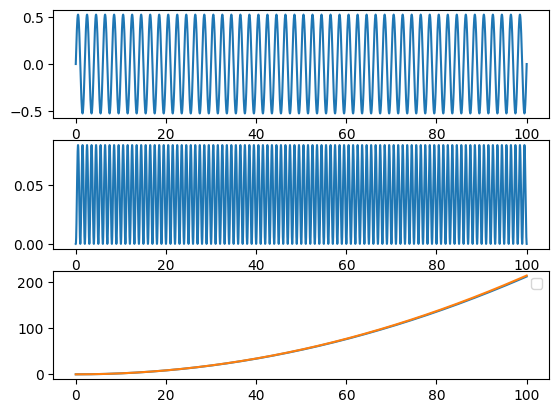

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1.5
H = 0.285*fork_length
L = 0.1*H
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2

m = 4
N = 100  # number of fin elements
dr = L/N  # length of each element

omega = np.pi
theta0_max = 0.125  # max angle in radians

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha[0], alpha[1], alpha[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal(xf, r, alpha, theta):
  v_n = xf[1] * np.sin(alpha[0]) + r * (alpha[1] + theta[1])
  return v_n

def vd_normal(xf, r, alpha, theta):
  dv_n = r * (theta[2] + alpha[2]) + alpha[1] * xf[1] * np.cos(alpha[0]) + xf[2] * np.sin(alpha[0])
  return dv_n

def dFd_a(dv_n):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha, theta):
  dFd = dFd_a(vd_normal(xf, r, alpha, theta)) + dFd_s(v_normal(xf, r, alpha, theta))
  return dFd

def Fd(xf, alpha, theta):

  dFd = np.zeros(num)

  for i in range(N):
    r = i * dr
    dFd[i] = dFd_net(xf, r, alpha, theta)

  Fd = np.sum(dFd)

  return Fd

def Ft_fun(xf, alpha, theta):
  Ft = - np.sin(alpha[0]) * Fd(xf, alpha, theta)
  return Ft

def Ft_analytical_fun(xf, alpha):
  Ft = - rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.sin(alpha[0]) - 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.sin(alpha[0])
  return Ft

def Fp_fun(xf, alpha, theta):
  Fp = np.cos(alpha[0]) * Fd(xf, alpha, theta)
  return Fp

def Fp_analytical_fun(xf, alpha):
  Fp = rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.cos(alpha[0]) + 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.cos(alpha[0])
  return Fp

# time
total_time = 100  # total time for the journey in seconds
num = 100000
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
alpha = np.zeros((3, num))

alpha[0] = np.pi/6 * np.sin(omega * t)
alpha[1] = omega * np.pi/6 * np.cos(omega * t)
alpha[2] = - omega**2 * np.pi/6 * np.sin(omega * t)

theta = [0, 0, 0] # Fish does not rotate

dt = total_time / num # differential time

Ft = np.zeros(num)

# anlytical values
xf_analytical = np.zeros((3, num))
Ft_analytical = np.zeros(num)

# Eulers method
for i in range(num):
  Ft[i] = Ft_fun(xf[:,i], alpha[:,i], theta)
  Ft_analytical[i] = Ft_analytical_fun(xf_analytical[:,i], alpha[:,i])
  xf[2,i] = Ft[i-1]/m
  xf[1,i] = xf[1,i-1] + xf[2,i-1] * dt
  xf[0,i] = xf[0,i-1] + xf[1,i-1] * dt
  xf_analytical[2,i] = Ft_analytical[i-1]/m
  xf_analytical[1,i] = xf_analytical[1,i-1] + xf_analytical[2,i-1] * dt
  xf_analytical[0,i] = xf_analytical[0,i-1] + xf_analytical[1,i-1] * dt


plt.subplot(3, 1, 1)
plt.plot(t, alpha[0], label = 'alpha')
# plt.plot(t, alpha[1], label = 'alphad')
# plt.plot(t, alpha[2], label = 'alphadd')

plt.subplot(3,1,2)
plt.plot(t, xf[2])

plt.subplot(3,1,3)
plt.plot(t, xf[0])
plt.plot(t, xf_analytical[0])

plt.legend()

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_value = rmse(xf[0], xf_analytical[0])
print("RMSE:", rmse_value)


RMSE with acc: 0.0089473300897022

RMSE w/o acc : 0.0089473300897022

# Incorporating RK Method with the previous model

The RK method works fine when excluding acceleration

RMSE: 0.0032572276825680586


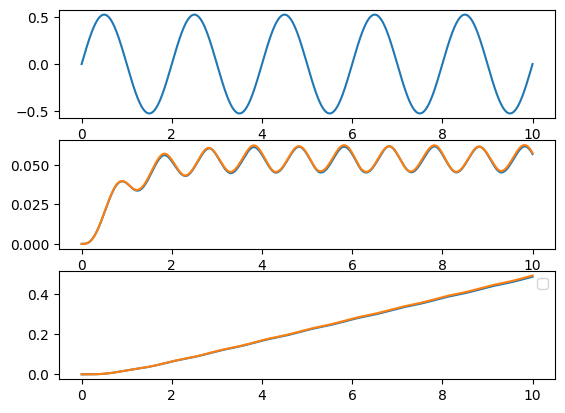

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1.5
H = 0.285*fork_length
L = 0.1*H
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2

m = 4
N = 100  # number of fin elements
dr = L/N  # length of each element

omega = np.pi
theta0_max = 0.125  # max angle in radians

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha[0], alpha[1], alpha[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal(xf, r, alpha, theta):
  v_n = xf[1] * np.sin(alpha[0]) + r * (alpha[1] + theta[1])
  return v_n

def vd_normal(xf, r, alpha, theta):
  dv_n = r * (theta[2] + alpha[2]) + alpha[1] * xf[1] * np.cos(alpha[0]) 
  return dv_n

def dFd_a(dv_n):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha, theta):
  dFd = dFd_a(vd_normal(xf, r, alpha, theta)) + dFd_s(v_normal(xf, r, alpha, theta))
  return dFd

def Fd(xf, alpha, theta):

  dFd = np.zeros(num)

  for i in range(N):
    r = i * dr
    dFd[i] = dFd_net(xf, r, alpha, theta)

  Fd = np.sum(dFd)

  return Fd

def Ft_fun(xf, alpha, theta):
  Ft = - np.sin(alpha[0]) * Fd(xf, alpha, theta)
  return Ft

def Ft_analytical_fun(xf, alpha):
  Ft = - rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.sin(alpha[0]) - 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.sin(alpha[0])
  return Ft

def Fp_fun(xf, alpha, theta):
  Fp = np.cos(alpha[0]) * Fd(xf, alpha, theta)
  return Fp

def Fp_analytical_fun(xf, alpha):
  Fp = rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.cos(alpha[0]) + 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.cos(alpha[0])
  return Fp

def fish_drag(xf):
  drag = 0.5 * rho * CD_fish * SA_fish_front * xf[1]**2
  return drag

# time
total_time = 10  # total time for the journey in seconds
num = 1000
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
theta = np.zeros((3, num)) # Fish does not rotate
alpha = np.zeros((3, num))

def get_alpha(t, omega):
  alpha = np.pi/6 * np.sin(omega * t)
  alphad = omega * np.pi/6 * np.cos(omega * t)
  alphadd = - omega**2 * np.pi/6 * np.sin(omega * t)

  return [alpha, alphad, alphadd]


alpha[0] = np.pi/6 * np.sin(omega * t)
alpha[1] = omega * np.pi/6 * np.cos(omega * t)
alpha[2] = - omega**2 * np.pi/6 * np.sin(omega * t)


dt = total_time / num # differential time

Ft = np.zeros(num)

# anlytical values
xf_analytical = np.zeros((3, num))
Ft_analytical = np.zeros(num)

def equations_of_motion(t, z, ax, theta):
  alpha = get_alpha(t, omega)
  x = z[0]
  vx = z[1]
  dvx_dt = (Ft_fun([x, vx, ax], alpha, theta) - fish_drag([x, vx, ax]))/m

  return [vx, dvx_dt]

def equations_of_motion_analytical(t, z, ax, theta):
  alpha = get_alpha(t, omega)
  x = z[0]
  vx = z[1]
  dvx_dt = (Ft_analytical_fun([x, vx, ax], alpha) - fish_drag([x, vx, ax]))/m

  return [vx, dvx_dt]


sol = solve_ivp(equations_of_motion, [0, 10], [xf[0, 0], xf[1, 0]], args=( 0,  theta[:,0]), t_eval=t)
sol_analytical = solve_ivp(equations_of_motion_analytical, [0, 10], [xf[0, 0], xf[1, 0]], args=( 0,  theta[:,0]), t_eval=t)

xf[0] = sol.y[0]
xf[1] = sol.y[1]
xf_analytical[0] = sol_analytical.y[0]
xf_analytical[1] = sol_analytical.y[1]

plt.subplot(3, 1, 1)
plt.plot(t, alpha[0], label = 'alpha')
# plt.plot(t, alpha[1], label = 'alphad')
# plt.plot(t, alpha[2], label = 'alphadd')

plt.subplot(3,1,2)
plt.plot(t, xf[1])
plt.plot(t, xf_analytical[1])

plt.subplot(3,1,3)
plt.plot(t, xf[0])
plt.plot(t, xf_analytical[0])

plt.legend()

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_value = rmse(xf[0], xf_analytical[0])
print("RMSE:", rmse_value)

# RK Method but with acc

THe method I used does not properly predict the way acceleration should behave when comparing it with the Eulers method. But since the acceleration only varies from 0 to 0.01 based on the analytical solution solved with Euler, we could sfely ignore its effects. This also means we can ignore anhgular accelerations effects as well.

Streaming output truncated to the last 5000 lines.
   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 6.867e+00  6.877e+00 ...  9.980e+00  9.990e+00]
        y: [[ 9.903e-01  9.933e-01 ...  2.001e+00  2.005e+00]
            [ 2.990e-01  3.005e-01 ...  4.041e-01  4.044e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0 

687  is done

sol for i is 
   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 6.877e+00  6.887e+00 ...  9.980e+00  9.990e+00]
        y: [[ 9.933e-01  9.963e-01 ...  2.000e+00  2.005e+00]
            [ 3.005e-01  3.019e-01 ...  4.037e-01  4.040e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 50
     njev: 0
      nlu: 0 

688  is done

sol for i is 
   message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: 

RMSE: 0.07426453758001457


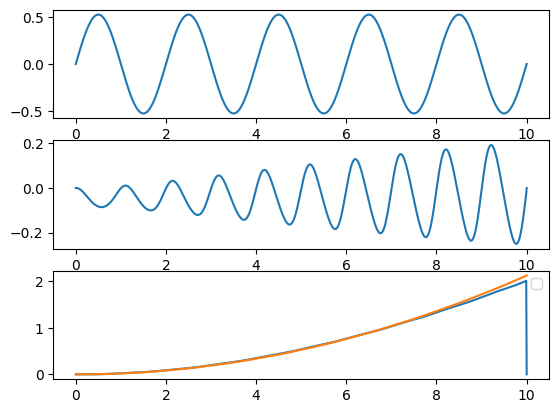

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1.5
H = 0.285*fork_length
L = 0.1*H
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2

m = 4
N = 100  # number of fin elements
dr = L/N  # length of each element

omega = np.pi
theta0_max = 0.125  # max angle in radians

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha[0], alpha[1], alpha[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal(xf, r, alpha, theta):
  v_n = xf[1] * np.sin(alpha[0]) + r * (alpha[1] + theta[1])
  return v_n

def vd_normal(xf, r, alpha, theta):
  dv_n = r * (theta[2] + alpha[2]) + alpha[1] * xf[1] * np.cos(alpha[0]) 
  return dv_n

def dFd_a(dv_n):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha, theta):
  dFd = dFd_a(vd_normal(xf, r, alpha, theta)) + dFd_s(v_normal(xf, r, alpha, theta))
  return dFd

def Fd(xf, alpha, theta):

  dFd = np.zeros(num)

  for i in range(N):
    r = i * dr
    dFd[i] = dFd_net(xf, r, alpha, theta)

  Fd = np.sum(dFd)

  return Fd

def Ft_fun(xf, alpha, theta):
  Ft = - np.sin(alpha[0]) * Fd(xf, alpha, theta)
  return Ft

def Ft_analytical_fun(xf, alpha):
  Ft = - rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.sin(alpha[0]) - 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.sin(alpha[0])
  return Ft

def Fp_fun(xf, alpha, theta):
  Fp = np.cos(alpha[0]) * Fd(xf, alpha, theta)
  return Fp

def Fp_analytical_fun(xf, alpha):
  Fp = rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.cos(alpha[0]) + 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.cos(alpha[0])
  return Fp

# time
total_time = 10  # total time for the journey in seconds
num = 1000
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
theta = np.zeros((3, num)) # Fish does not rotate
alpha = np.zeros((3, num))

def get_alpha(t, omega):
  alpha = np.pi/6 * np.sin(omega * t)
  alphad = omega * np.pi/6 * np.cos(omega * t)
  alphadd = - omega**2 * np.pi/6 * np.sin(omega * t)

  return [alpha, alphad, alphadd]


alpha[0] = np.pi/6 * np.sin(omega * t)
alpha[1] = omega * np.pi/6 * np.cos(omega * t)
alpha[2] = - omega**2 * np.pi/6 * np.sin(omega * t)


dt = total_time / num # differential time

Ft = np.zeros(num)

# anlytical values
xf_analytical = np.zeros((3, num))
Ft_analytical = np.zeros(num)

def equations_of_motion(t, z, ax, theta):
  alpha = get_alpha(t, omega)
  x = z[0]
  vx = z[1]
  dvx_dt = Ft_fun([x, vx, ax], alpha, theta)/m

  return [vx, dvx_dt]

'''
sol = solve_ivp(equations_of_motion, [0, 10], [xf[0, 0], xf[1, 0]], args=( 0,  theta[:,0]), t_eval=t)

xf[0] = sol.y[0]
xf[1] = sol.y[1]
'''

for i in range(num-2):
  sol = solve_ivp(equations_of_motion, [t[i], t[num-1]], [xf[0, i], xf[1, i]], args=( xf[2, i],  theta[:,i]), t_eval=t[i : num-1])
  print(i," is done\n")
  print("sol for i is \n",sol,"\n")
  xf[0,i+1] = sol.y[0,1]
  xf[1,i+1] = sol.y[1,1]
  xf[2,i+1] = ( sol.y[1,0]- sol.y[1,1])/dt


# Eulers Metho
for i in range(num):
  Ft_analytical[i] = Ft_analytical_fun(xf_analytical[:,i], alpha[:,i])

  xf_analytical[2,i] = Ft_analytical[i-1]/m
  xf_analytical[1,i] = xf_analytical[1,i-1] + xf_analytical[2,i-1] * dt
  xf_analytical[0,i] = xf_analytical[0,i-1] + xf_analytical[1,i-1] * dt



plt.subplot(3, 1, 1)
plt.plot(t, alpha[0], label = 'alpha')
# plt.plot(t, alpha[1], label = 'alphad')
# plt.plot(t, alpha[2], label = 'alphadd')

plt.subplot(3,1,2)
plt.plot(t, xf[2])

plt.subplot(3,1,3)
plt.plot(t, xf[0])
plt.plot(t, xf_analytical[0])

plt.legend()

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

rmse_value = rmse(xf[0], xf_analytical[0])
print("RMSE:", rmse_value)

In [ ]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 9.980e+00  9.990e+00]
        y: [[ 2.002e+00  2.007e+00]
            [ 4.056e-01  4.059e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 8
     njev: 0
      nlu: 0

# Adding Rotation of fish

The starting direction of the fin flap affects the drift of the fish theta. 

When adding a drag value for rotation we see interesting behaviour. Must ask prof for best move forward


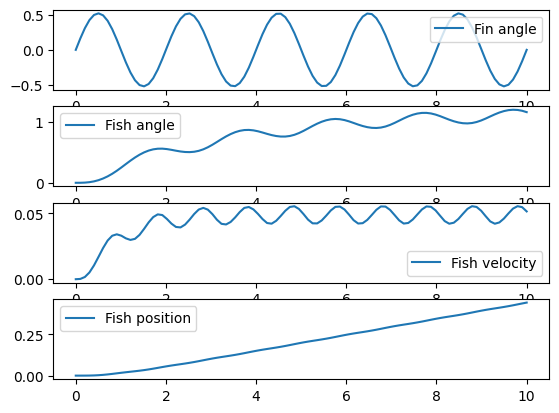

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1.5
H = 0.285*fork_length
L = 0.1*H
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2
C_rd = 0.01 # coeff of rotational drag

m = 4
N = 100  # number of fin elements
dr = L/N  # length of each element

omega = np.pi
theta0_max = 0.125  # max angle in radians

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# time
total_time = 10  # total time for the journey in seconds
num = total_time * 10
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
theta = np.zeros((3, num)) 
alpha = np.zeros((3, num))

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha[0], alpha[1], alpha[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal(xf, r, alpha, theta):
  v_n = xf[1] * np.sin(alpha[0]) + r * (alpha[1] + theta[1])
  return v_n

def vd_normal(xf, r, alpha, theta):
  dv_n = r * (theta[2] + alpha[2]) + alpha[1] * xf[1] * np.cos(alpha[0]) + xf[2] * np.sin(alpha[0])
  return dv_n

def dFd_a(dv_n):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha, theta):
  dFd = dFd_a(vd_normal(xf, r, alpha, theta)) + dFd_s(v_normal(xf, r, alpha, theta))
  return dFd

def Fd(xf, alpha, theta):

  dFd = np.zeros(num)

  for i in range(N):
    r = i * dr
    dFd[i] = dFd_net(xf, r, alpha, theta)

  Fd = np.sum(dFd)

  return Fd

def Ft_fun(xf, alpha, theta):
  Ft = - np.sin(alpha[0]) * Fd(xf, alpha, theta)
  return Ft

def Ft_analytical_fun(xf, alpha):
  Ft = - rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.sin(alpha[0]) - 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.sin(alpha[0])
  return Ft

def Fp_fun(xf, alpha, theta):
  Fp = np.cos(alpha[0]) * Fd(xf, alpha, theta)
  return Fp

def Fp_analytical_fun(xf, alpha):
  Fp = rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.cos(alpha[0]) + 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.cos(alpha[0])
  return Fp

def dT_fun(xf, r, alpha, theta):
  dT = - dFd_net(xf, r, alpha, theta) * (np.cos(alpha[0] * L_fish/2 + r))
  return dT

def T_fun(xf, alpha, theta):

  dT = np.zeros(num)

  for i in range(N):
    r = i * dr
    dT[i] = dT_fun(xf, r, alpha, theta)

  T = np.sum(dT)

  return T

def fish_drag(xf):
  drag = 0.5 * rho * CD_fish * SA_fish_front * xf[1]**2
  return drag

def rotation_drag(alpha):
  drag = 0.5 * rho * (alpha[1] * L_fish/4) * np.abs(alpha[1] * L_fish/4) * L_fish * H_fish * C_rd
  return drag


def get_alpha(t, omega):
  alpha = np.pi/6 * np.sin(omega * t)
  alphad = omega * np.pi/6 * np.cos(omega * t)
  alphadd = - omega**2 * np.pi/6 * np.sin(omega * t)
  return [alpha, alphad, alphadd]

dt = total_time / num # differential time

Ft = np.zeros(num)

def equations_of_motion(t, z, ax, thetadd):
  alpha = get_alpha(t, omega)
  x, vx, theta, thetad = z
  rot_drag = rotation_drag([theta, thetad, thetadd])
  thetadd = (T_fun([x, vx, ax], alpha, [theta, thetad, thetadd]) - rot_drag)/I_fish
  dvx_dt =  (Ft_fun([x, vx, ax], alpha, [theta, thetad, thetadd]) - fish_drag([x, vx, ax]))/m

  return [vx, dvx_dt, thetad, thetadd]

sol = solve_ivp(equations_of_motion, [0, total_time], [xf[0, 0], xf[1, 0], theta[0, 0], theta[1, 0]], args=( 0, 0), t_eval=t)

xf[0] = sol.y[0]
xf[1] = sol.y[1]
theta[0] = sol.y[2]
theta[1] = sol.y[3]
alpha = np.pi/6 * np.sin(omega * t)

plt.subplot(4,1,1)
plt.plot(t, alpha, label = "Fin angle")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t, theta[0], label = "Fish angle")
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, xf[1], label = "Fish velocity")
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, xf[0], label = "Fish position")
plt.legend()

# Two Fin

Add two fins

The vn and dvn values are different depending on the fin being calculated for. The torque fiunction also changes

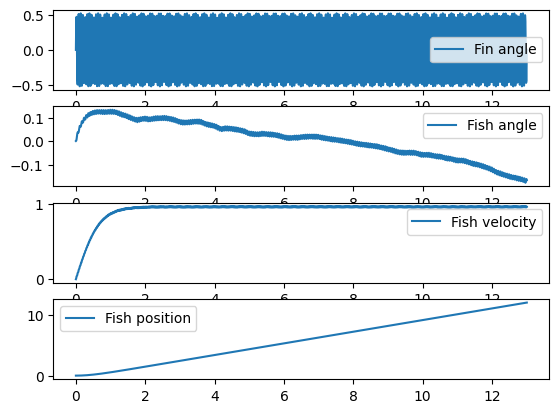

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1
H = 0.285*fork_length
L = 0.1*H
element_ratio = 1 # L2 = element_ratio * L1
# L1 + L2 = L
# L1 + L1 * element_ratio = L
L1 = L / (1 + element_ratio)
L2 = L - L1
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2
C_rd = 1 # coeff of rotational drag

m = 18
N = 100  # number of fin elements
## Dont forget to define dr = L/N

omega = 32*np.pi
theta0_max = 0.125  # max angle in radians

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# time
total_time = 13  # total time for the journey in seconds
num = total_time * 100
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
theta = np.zeros((3, num)) 
alpha1 = np.zeros((3, num))
alpha2 = np.zeros((3, num))

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha1[0], alpha1[1], alpha1[2] => Fin angle, angular velocity, angular acceleration
# alpha2[0], alpha2[1], alpha2[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal_1(xf, r, alpha1, theta):
  v_n = xf[1] * np.sin(alpha1[0]) + r * (alpha1[1] + theta[1])
  return v_n

def v_normal_2(xf, r, alpha1, alpha2, theta):
  v_n = xf[1] * np.sin(alpha2[0]) + r * (alpha2[1] + theta[1]) + L1 * (theta[1] + alpha1[1]) * np.cos(alpha2[0]-alpha1[0])
  return v_n

def vd_normal_1(xf, r, alpha1, theta):
  dv_n = r * (theta[2] + alpha1[2]) + alpha1[1] * xf[1] * np.cos(alpha1[0]) + xf[2] * np.sin(alpha1[0])
  return dv_n

def vd_normal_2(xf, r, alpha1, alpha2, theta):
  dv_n = r * alpha2[2] + alpha2[1] * xf[1] * np.cos(alpha2[0]) + L1 * alpha1[2] * np.cos(alpha2[0] + alpha1[0]) - L1 * (theta[1] + alpha1[1]) * (alpha2[1] - alpha1[1]) * np.sin(alpha2[0] - alpha1[0])
  return dv_n

def dFd_a(dv_n, dr):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n, dr):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha1, alpha2, theta, dr, fin):
  if fin == 1:
    dFd = dFd_a(vd_normal_1(xf, r, alpha1, theta), dr) + dFd_s(v_normal_1(xf, r, alpha1, theta), dr)
  else:
    dFd = dFd_a(vd_normal_2(xf, r, alpha1, alpha2, theta), dr) + dFd_s(v_normal_2(xf, r, alpha1, alpha2, theta), dr)
  return dFd

def Fd_fin(t, xf, theta, phi, fin):

  dFd = np.zeros(num)
  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phi)

  if fin == 1:
    dr = L1/N
    for i in range(N):
      r = i * dr
      dFd[i] = dFd_net(xf, r, alpha1, alpha2, theta, dr, fin)
  else:
    dr = L2/N
    for i in range(N):
      r = i * dr
      dFd[i] = dFd_net(xf, r, alpha1, alpha2, theta, dr, fin)

  Fd = np.sum(dFd)

  return Fd

def Ft_fun(t, xf, theta, phi):

  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phi)

  Ft1 = - np.sin(alpha1[0]) * Fd_fin(t, xf, theta, 0, 1)
  Ft2 = - np.sin(alpha2[0]) * Fd_fin(t, xf, theta, phi, 2)

  Ft = Ft1 + Ft2

  return Ft

def Ft_analytical_fun(xf, alpha):
  Ft = - rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.sin(alpha[0]) - 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.sin(alpha[0])
  return Ft

def Fp_fun(xf, alpha, theta):

  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phi)

  Fp1 = - np.cos(alpha1[0]) * Fd_fin(t, xf, theta, 0)
  Fp2 = - np.cos(alpha2[0]) * Fd_fin(t, xf, theta, phi)

  Fp = Fp1 + Fp2
  return Fp

def Fp_analytical_fun(xf, alpha):
  Fp = rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.cos(alpha[0]) + 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.cos(alpha[0])
  return Fp

def dT_fun(xf, r, alpha1, alpha2, theta, dr, fin):

  if fin == 1:
    dT = - dFd_net(xf, r, alpha1, alpha2, theta, dr, fin) * (np.cos(alpha1[0] * L_fish/2 + r))
  else:
    dT = - dFd_net(xf, r, alpha1, alpha2, theta, dr, fin) * (np.cos(alpha2[0] * L_fish/2 + r + L1 * np.cos(alpha2[0]-alpha1[0])))
  return dT

def T_tot(t, xf, theta, phi):

  dT1 = np.zeros(N)

  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phi)

  dr = L1/N
  fin = 1
  for i in range(N):
    r = i * dr
    dT1[i] = dT_fun(xf, r, alpha1, alpha2, theta, dr, fin)

  T1 = np.sum(dT1)
  
  dT2 = np.zeros(N)

  fin = 2
  dr = L2/N
  for i in range(N):
    r = i * dr
    dT2[i] = dT_fun(xf, r, alpha1, alpha2, theta, dr, fin)

  T2 = np.sum(dT2)

  T = T1 + T2

  return T

def fish_drag(xf):
  drag = 0.5 * rho * CD_fish * SA_fish_front * xf[1]**2
  return drag

def rotation_drag(alpha):
  drag = 0.5 * rho * (alpha[1] * L_fish/4) * np.abs(alpha[1] * L_fish/4) * L_fish * H_fish * C_rd
  return drag


def get_alpha(t, omega, phi):
  alpha = np.pi/6 * np.sin(omega * t + phi)
  alphad = omega * np.pi/6 * np.cos(omega * t + phi)
  alphadd = - omega**2 * np.pi/6 * np.sin(omega * t + phi)
  return [alpha, alphad, alphadd]

dt = total_time / num # differential time

Ft = np.zeros(num)

def equations_of_motion(t, z, ax, thetadd, phi):
  x, vx, theta, thetad = z
  theta_temp = [theta, thetad, thetadd]
  x_temp = [x, vx, ax]
  rot_drag = rotation_drag(theta_temp)
  if np.abs(rot_drag) > np.abs(T_tot(t, x_temp, theta_temp, phi)):
    rot_drag = T_tot(t, x_temp, theta_temp, phi)
  thetadd = (T_tot(t, x_temp, theta_temp, phi) - rot_drag)/I_fish
  dvx_dt =  (Ft_fun(t, x_temp, theta_temp, phi) - fish_drag(x_temp))/m

  return [vx, dvx_dt, thetad, thetadd]

sol = solve_ivp(equations_of_motion, [0, total_time], [xf[0, 0], xf[1, 0], theta[0, 0], theta[1, 0]], args=( 0, 0, np.pi/6), t_eval=t)  # args: ax, thetadd, phi

xf[0] = sol.y[0]
xf[1] = sol.y[1]
theta[0] = sol.y[2]
theta[1] = sol.y[3]
alpha = np.pi/6 * np.sin(omega * t)

plt.subplot(4,1,1)
plt.plot(t, alpha, label = "Fin angle")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t, theta[0], label = "Fish angle")
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, xf[1], label = "Fish velocity")
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, xf[0], label = "Fish position")
plt.legend()

# Call Function for Optimization

Add these values: flipping_frequency, flipping_amplitude, phase_shift, target, amplitude_controller, elementRatio

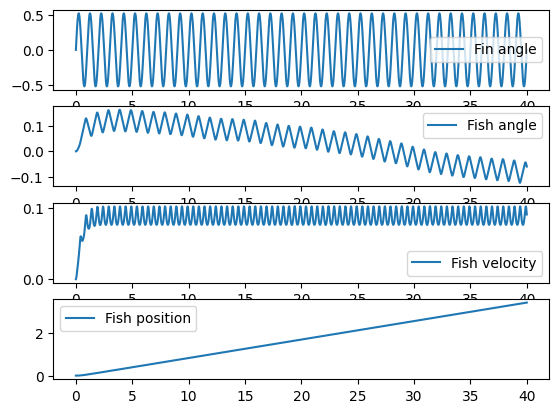

In [ ]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt

rho = 997  # water density in kg/m^3
fork_length = 1.5
H = 0.285*fork_length
L = 0.1*H
H_fish = 0.27*fork_length
L_fish = fork_length
SA_fish_front = H_fish**2
CD_fish = 0.75  # drag coefficient
CD_rect = 1.2
C_rd = 1 # coeff of rotational drag

m = 4
N = 100  # number of fin elements
## Dont forget to define dr = L/N

# Random Values defined here

flipping_frequency = 1 # Hz
flipping_amplitude = np.pi/3
phase_shift = np.pi/6
target = 1
amplitude_controller = 1
elementRatio = 1 # L2 = element_ratio * L1

omega = flipping_frequency * 2 * np.pi

# L1 + L2 = L
# L1 + L1 * element_ratio = L
L1 = L / (1 + element_ratio)
L2 = L - L1

I_fish = (1/12) * m * (L_fish**2 + H_fish**2)
Ma = rho * np.pi / 4 * H**2

# time
total_time = 40  # total time for the journey in seconds
num = total_time * 50
t = np.linspace(0, total_time, num)

xf = np.zeros((3, num))
theta = np.zeros((3, num)) 
alpha1 = np.zeros((3, num))
alpha2 = np.zeros((3, num))

# xf[0], xf[1], xf[2] => Fish position, Velocity, Acceleration
# alpha1[0], alpha1[1], alpha1[2] => Fin angle, angular velocity, angular acceleration
# alpha2[0], alpha2[1], alpha2[2] => Fin angle, angular velocity, angular acceleration
# theta[0], theta[1], theta[2] => Fish angle, angular velocity, angular acceleration
# v_n => normal velocity
# dv_n => dv_n/dt

def v_normal_1(xf, r, alpha1, theta):
  v_n = xf[1] * np.sin(alpha1[0]) + r * (alpha1[1] + theta[1])
  return v_n

def v_normal_2(xf, r, alpha1, alpha2, theta):
  v_n = xf[1] * np.sin(alpha2[0]) + r * (alpha2[1] + theta[1]) + L1 * (theta[1] + alpha1[1]) * np.cos(alpha2[0]-alpha1[0])
  return v_n

def vd_normal_1(xf, r, alpha1, theta):
  dv_n = r * (theta[2] + alpha1[2]) + alpha1[1] * xf[1] * np.cos(alpha1[0]) + xf[2] * np.sin(alpha1[0])
  return dv_n

def vd_normal_2(xf, r, alpha1, alpha2, theta):
  dv_n = r * alpha2[2] + alpha2[1] * xf[1] * np.cos(alpha2[0]) + L1 * alpha1[2] * np.cos(alpha2[0] + alpha1[0]) - L1 * (theta[1] + alpha1[1]) * (alpha2[1] - alpha1[1]) * np.sin(alpha2[0] - alpha1[0])
  return dv_n

def dFd_a(dv_n, dr):
  dFd_a = Ma * dv_n * dr
  return dFd_a

def dFd_s(v_n, dr):
  dFd_s = 0.5 * rho * v_n * np.abs(v_n) * CD_rect * H * dr
  return dFd_s

def dFd_net(xf, r, alpha1, alpha2, theta, dr, fin):
  if fin == 1:
    dFd = dFd_a(vd_normal_1(xf, r, alpha1, theta), dr) + dFd_s(v_normal_1(xf, r, alpha1, theta), dr)
  else:
    dFd = dFd_a(vd_normal_2(xf, r, alpha1, alpha2, theta), dr) + dFd_s(v_normal_2(xf, r, alpha1, alpha2, theta), dr)
  return dFd

def Fd_fin(t, xf, theta, phase_shift, fin):

  dFd = np.zeros(num)
  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phase_shift)

  if fin == 1:
    dr = L1/N
    for i in range(N):
      r = i * dr
      dFd[i] = dFd_net(xf, r, alpha1, alpha2, theta, dr, fin)
  else:
    dr = L2/N
    for i in range(N):
      r = i * dr
      dFd[i] = dFd_net(xf, r, alpha1, alpha2, theta, dr, fin)

  Fd = np.sum(dFd)

  return Fd

def Ft_fun(t, xf, theta, phase_shift):

  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phase_shift)

  Ft1 = - np.sin(alpha1[0]) * Fd_fin(t, xf, theta, 0, 1)
  Ft2 = - np.sin(alpha2[0]) * Fd_fin(t, xf, theta, phase_shift, 2)

  Ft = Ft1 + Ft2

  return Ft

def Ft_analytical_fun(xf, alpha):
  Ft = - rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.sin(alpha[0]) - 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.sin(alpha[0])
  return Ft

def Fp_fun(xf, alpha, theta):

  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phase_shift)

  Fp1 = - np.cos(alpha1[0]) * Fd_fin(t, xf, theta, 0)
  Fp2 = - np.cos(alpha2[0]) * Fd_fin(t, xf, theta, phase_shift)

  Fp = Fp1 + Fp2
  return Fp

def Fp_analytical_fun(xf, alpha):
  Fp = rho * np.pi/4 * H**2 * (0.5 * L**2 * alpha[2] + xf[1] * L * np.cos(alpha[0]) * alpha[1]) * np.cos(alpha[0]) + 0.5 * rho * CD_rect * H * ( L**3 / 3 * alpha[1]**2 + L**2 * xf[1] * alpha[1] * np.sin(alpha[0]) + xf[1]**2 * L * np.sin(alpha[0])**2) * np.cos(alpha[0])
  return Fp

def dT_fun(xf, r, alpha1, alpha2, theta, dr, fin):

  if fin == 1:
    dT = - dFd_net(xf, r, alpha1, alpha2, theta, dr, fin) * (np.cos(alpha1[0] * L_fish/2 + r))
  else:
    dT = - dFd_net(xf, r, alpha1, alpha2, theta, dr, fin) * (np.cos(alpha2[0] * L_fish/2 + r + L1 * np.cos(alpha2[0]-alpha1[0])))
  return dT

def T_tot(t, xf, theta, phase_shift):

  dT1 = np.zeros(N)

  alpha1 = get_alpha(t, omega, 0)
  alpha2 = get_alpha(t, omega, phase_shift)

  dr = L1/N
  fin = 1
  for i in range(N):
    r = i * dr
    dT1[i] = dT_fun(xf, r, alpha1, alpha2, theta, dr, fin)

  T1 = np.sum(dT1)
  
  dT2 = np.zeros(N)

  fin = 2
  dr = L2/N
  for i in range(N):
    r = i * dr
    dT2[i] = dT_fun(xf, r, alpha1, alpha2, theta, dr, fin)

  T2 = np.sum(dT2)

  T = T1 + T2

  return T

def fish_drag(xf):
  drag = 0.5 * rho * CD_fish * SA_fish_front * xf[1]**2
  return drag

def rotation_drag(alpha):
  drag = 0.5 * rho * (alpha[1] * L_fish/4) * np.abs(alpha[1] * L_fish/4) * L_fish * H_fish * C_rd
  return drag


def get_alpha(t, omega, phase_shift):
  alpha = flipping_amplitude * np.sin(omega * t + phase_shift)
  alphad = omega * np.pi/6 * np.cos(omega * t + phase_shift)
  alphadd = - omega**2 * np.pi/6 * np.sin(omega * t + phase_shift)
  return [alpha, alphad, alphadd]

dt = total_time / num # differential time

Ft = np.zeros(num)

def equations_of_motion(t, z, ax, thetadd, phase_shift):
  x, vx, theta, thetad = z
  theta_temp = [theta, thetad, thetadd]
  x_temp = [x, vx, ax]
  rot_drag = rotation_drag(theta_temp)
  if np.abs(rot_drag) > np.abs(T_tot(t, x_temp, theta_temp, phase_shift)):
    rot_drag = T_tot(t, x_temp, theta_temp, phase_shift)
  thetadd = (T_tot(t, x_temp, theta_temp, phase_shift) - rot_drag)/I_fish
  dvx_dt =  (Ft_fun(t, x_temp, theta_temp, phase_shift) - fish_drag(x_temp))/m

  return [vx, dvx_dt, thetad, thetadd]

sol = solve_ivp(equations_of_motion, [0, total_time], [xf[0, 0], xf[1, 0], theta[0, 0], theta[1, 0]], args=( 0, 0, np.pi/6), t_eval=t)  # args: ax, thetadd, phase_shift

xf[0] = sol.y[0]
xf[1] = sol.y[1]
theta[0] = sol.y[2]
theta[1] = sol.y[3]
alpha = np.pi/6 * np.sin(omega * t)

plt.subplot(4,1,1)
plt.plot(t, alpha, label = "Fin angle")
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t, theta[0], label = "Fish angle")
plt.legend()

plt.subplot(4,1,3)
plt.plot(t, xf[1], label = "Fish velocity")
plt.legend()

plt.subplot(4,1,4)
plt.plot(t, xf[0], label = "Fish position")
plt.legend()

# Fish Coordinate system

<ipython-input-17-b13abf4b9b3b>:65: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Arc(arc_center, 2 * arc_radius, 2 * arc_radius, 0, arc_start_angle, arc_end_angle, color='r'))
<ipython-input-17-b13abf4b9b3b>:77: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Arc(arc_center, 2 * arc_radius, 2 * arc_radius, 0, arc_start_angle, arc_end_angle, color='r'))


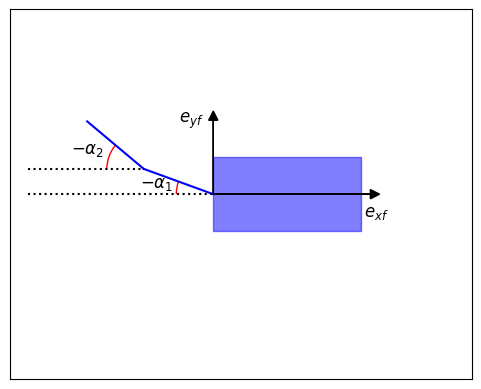

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# Define the fish body dimensions
body_width = 8
body_height = 4

# Define the fin length and angle
fin_length = 4
alpha1 = np.radians(70)  # Convert alpha1 to radians
alpha2 = np.radians(50)

# Create the figure and axes
fig, ax = plt.subplots()

# Set the aspect ratio to equal
ax.set_aspect('equal')

# Set the limits of the plot
ax.set_xlim([-15, 10])
ax.set_ylim([-10, 10])

# Draw the fish body rectangle
body_rect = plt.Rectangle((-body_width / 2, -body_height / 2), body_width, body_height, fill=True, color='b', alpha = 0.5)
ax.add_patch(body_rect)

# Calculate the fin coordinates
fin_x = np.array([-body_width / 2, -body_width / 2 - fin_length * np.sin(alpha1)])
fin_y = np.array([0, fin_length * np.cos(alpha1)])

# Draw the fin line
ax.plot(fin_x, fin_y, color='b')

# Calculate the fin 2 coordinates
fin2_x = np.array([-body_width / 2 - fin_length * np.sin(alpha1), -body_width / 2 - fin_length * np.sin(alpha1) - fin_length * np.sin(alpha2)])
fin2_y = np.array([fin_length * np.cos(alpha1), fin_length * np.cos(alpha1) + fin_length * np.cos(alpha2)])

# Draw the fin line
ax.plot(fin2_x, fin2_y, color='b')

# Draw the x and y axes for the fish body
ax.arrow(-body_width / 2, 0, body_width+0.5, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
ax.arrow(-body_width / 2, 0, 0, body_height, head_width=0.5, head_length=0.5, fc='k', ec='k')

# Draw the e_xf and e_yf labels
ax.text(body_width / 2+0.8, 0 - 0.5, r'$e_{xf}$', fontsize=12, ha='center', va='top')
ax.text(-body_width / 2 - 0.5, body_height, r'$e_{yf}$', fontsize=12, ha='right', va='center')

# Draw the dotted line for e_xf axis
dotted_line_x = np.array([-body_width / 2 - 10, -body_width / 2 - fin_length * np.sin(alpha1)])
dotted_line_y = np.array([fin_length * np.cos(alpha1), fin_length * np.cos(alpha1)])
ax.plot(dotted_line_x, dotted_line_y, color='k', linestyle='dotted')

# Draw the dotted line for the second fin
dotted_line_x = np.array([-body_width / 2 - 10, -body_width / 2])
dotted_line_y = np.array([0, 0])
ax.plot(dotted_line_x, dotted_line_y, color='k', linestyle='dotted')

# Draw the fin1 angle arc
arc_center = (-body_width / 2, 0)
arc_radius = 2
arc_start_angle = np.degrees(np.pi/2 + alpha1)
arc_end_angle = np.degrees(np.pi)
ax.add_patch(Arc(arc_center, 2 * arc_radius, 2 * arc_radius, 0, arc_start_angle, arc_end_angle, color='r'))

# Draw the fin1 angle label
angle_x = -body_width / 2 - fin_length * np.sin(alpha1) / 2 - 1.2
angle_y = fin_length * np.cos(alpha1) / 2 - 0.6
ax.text(angle_x, angle_y, r'$-\alpha_1$', fontsize=12, ha='center', va='bottom')

# Draw the fin2 angle arc
arc_center = (-body_width / 2 - fin_length * np.sin(alpha1), fin_length * np.cos(alpha1))
arc_radius = 2
arc_start_angle = np.degrees(np.pi/2 + alpha2)
arc_end_angle = np.degrees(np.pi)
ax.add_patch(Arc(arc_center, 2 * arc_radius, 2 * arc_radius, 0, arc_start_angle, arc_end_angle, color='r'))


# Draw the fin1 angle label
angle_x = -body_width / 2 - fin_length * np.sin(alpha1) - fin_length * np.sin(alpha2) / 2 - 1.5
angle_y = fin_length * np.cos(alpha1) + fin_length * np.cos(alpha2) / 2 - 0.7
ax.text(angle_x, angle_y, r'$-\alpha_2$', fontsize=12, ha='center', va='bottom')


# Remove x and y axis ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove x and y axis tick labels
ax.set_xticklabels([])
ax.set_yticklabels([])

# Display the plot
plt.show()
